In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-vs-cats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3362%2F31148%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T060720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51e6cee68ccd31636166b60e391ec95c5594afef38cbefc443cf674247632ae8db1a1e79b7d65278ef65084dfb8485381959e6e9bc85b23b4b675f7116411582316fa1e71f5369097d7ccc9f4f42496cf1ffa2c6ec80754477d5fdeaa20c95041933cb1752b26e47846a64228d73b11b88db969f8dc8de8c14be51bcc496e97d207eb93c63237343d7f46fdd353e0a9df70d7e3cbc106a3a126ca2c5336d4956afd9a59bdf245f350e213215ae4e1b6f25b592b4ef535ee612bfd169ce5435f9a1a8b122df48801a018843f8444cca9fbdb3fc220e6c50057cea0255d730d95af0fd16104a2597d5a1fd2c32e9a3e179ae2b4e06d0321ee9e1e7488024e5d746'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 851576689 bytes downloaded
Downloaded and uncompressed: dogs-vs-cats
Data source import complete.


 # Importing Required libraries

In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Extracting the datasets

In [3]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

# Setting up paths

In [4]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# Function to load and preprocess the images

In [5]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

# Visualize images with labels

In [6]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and visualize cat images

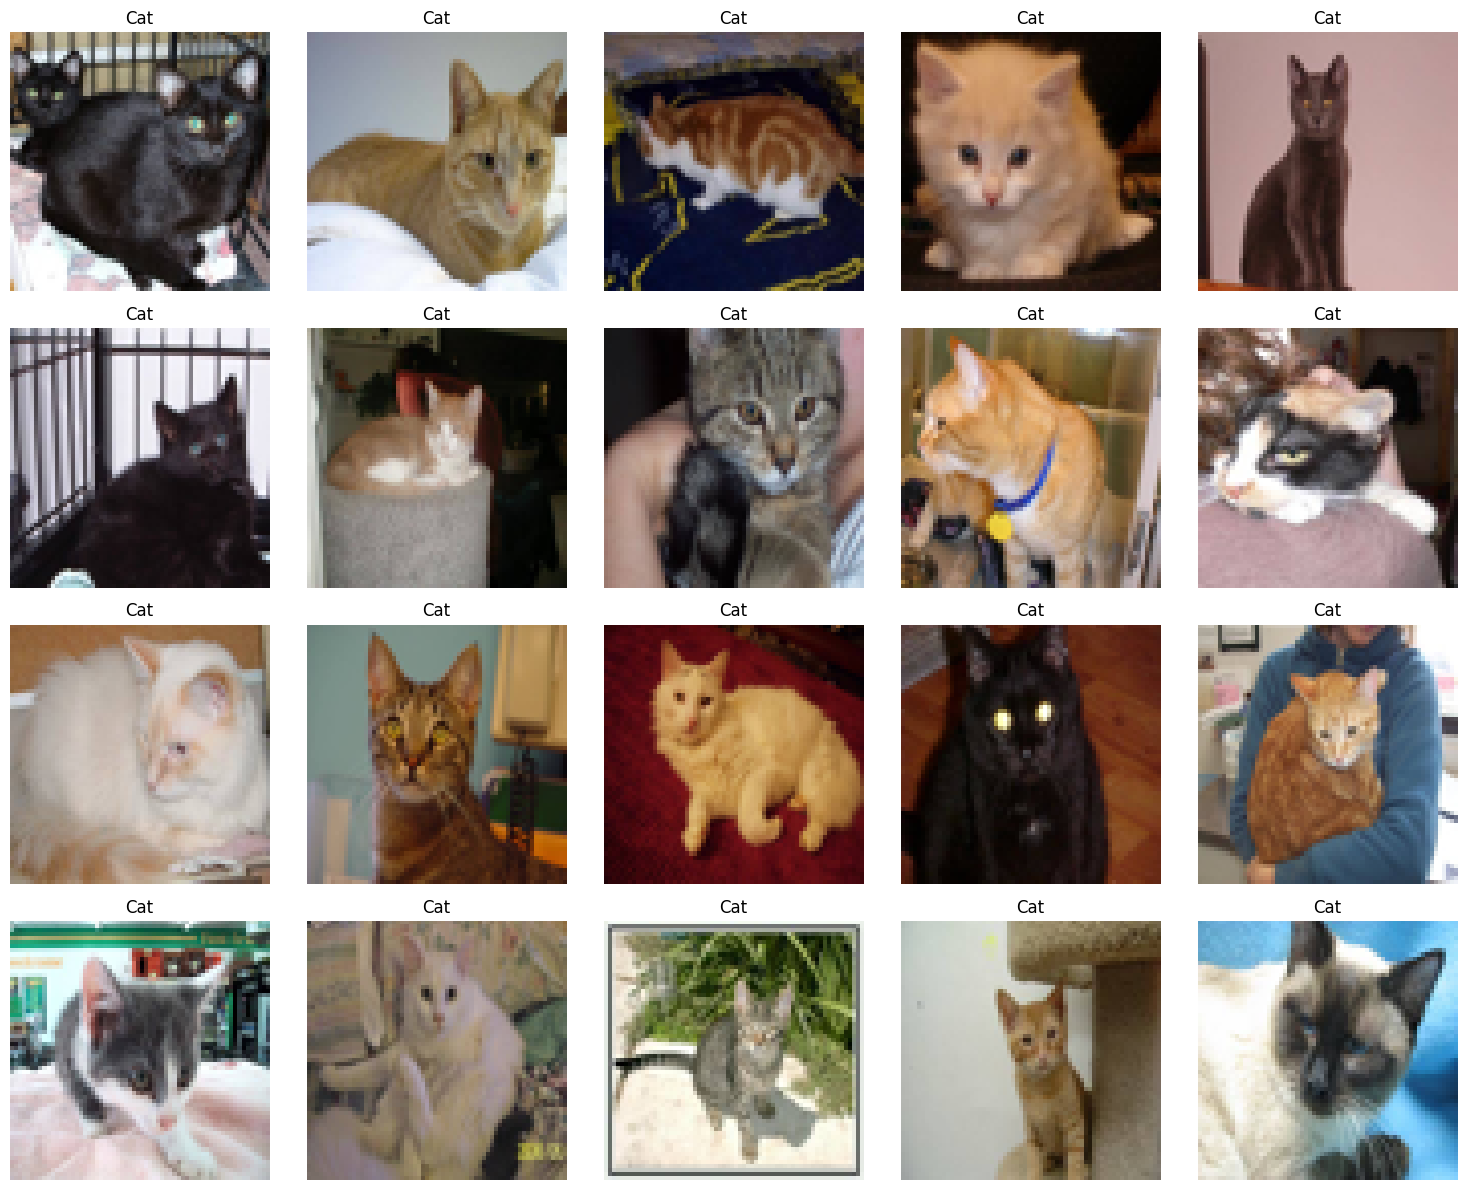

In [7]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

# Load and visualize dog images

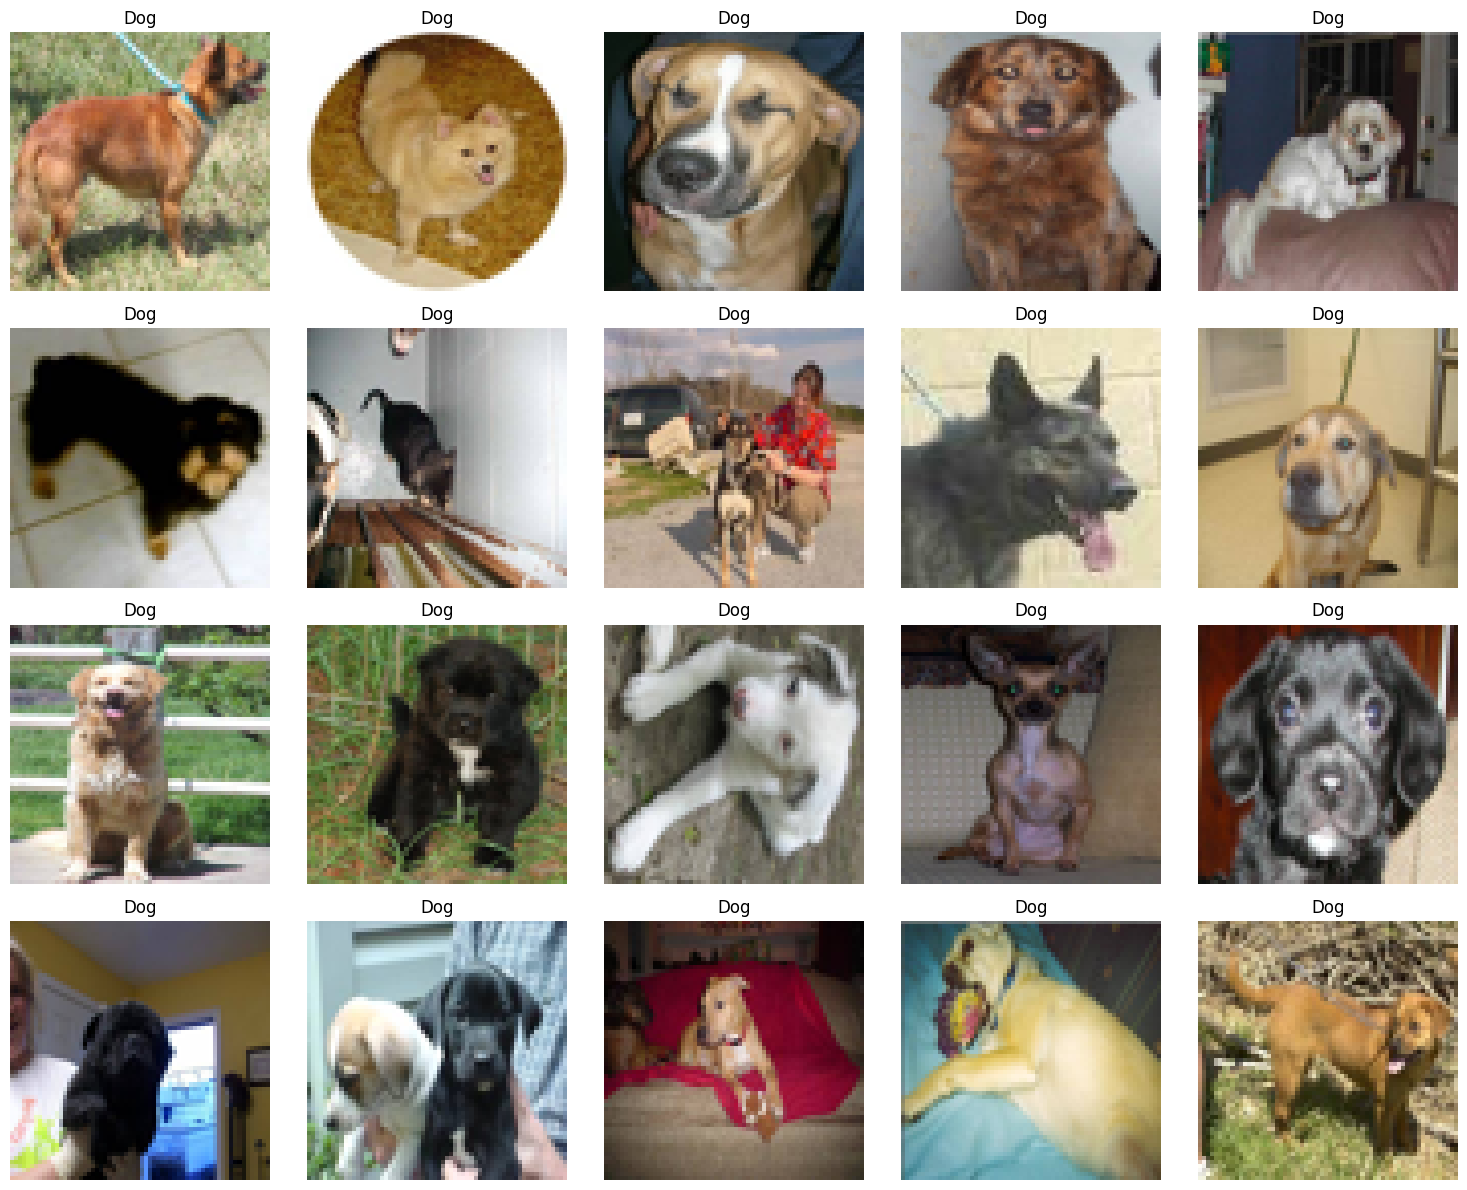

In [8]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

# Load and visualize both cat and dog images

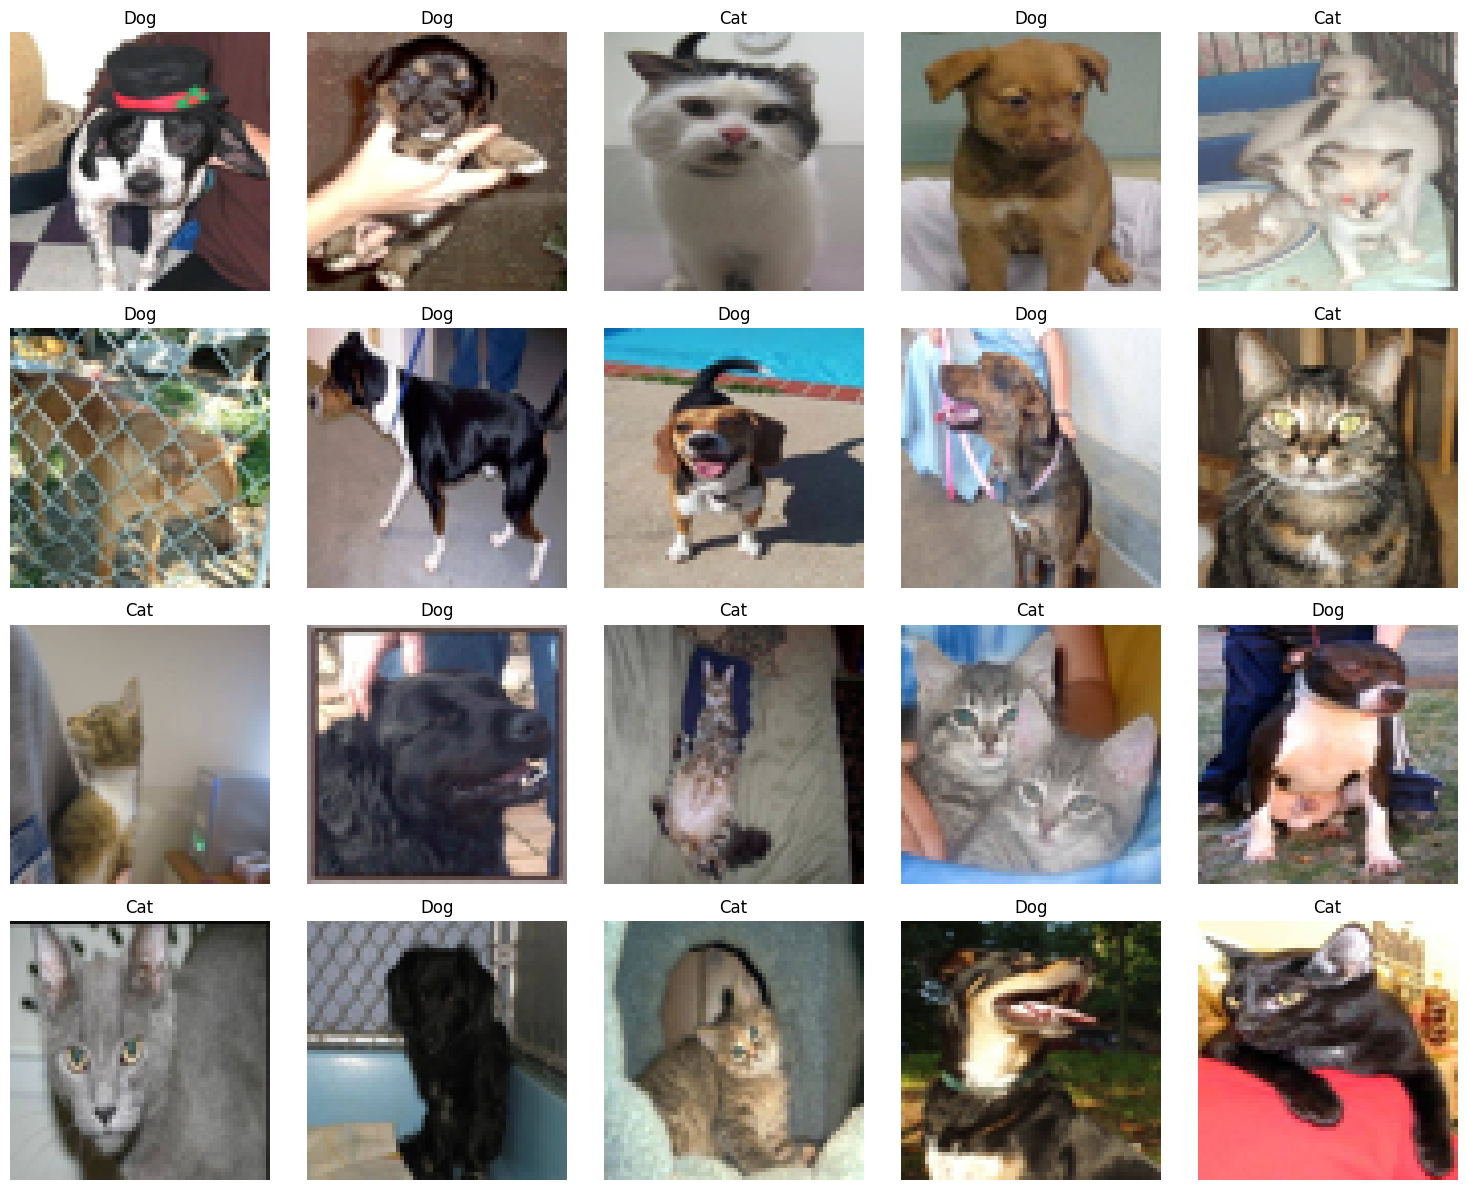

In [9]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# Loading and preprocessing the training data

# Display the shape of the images array

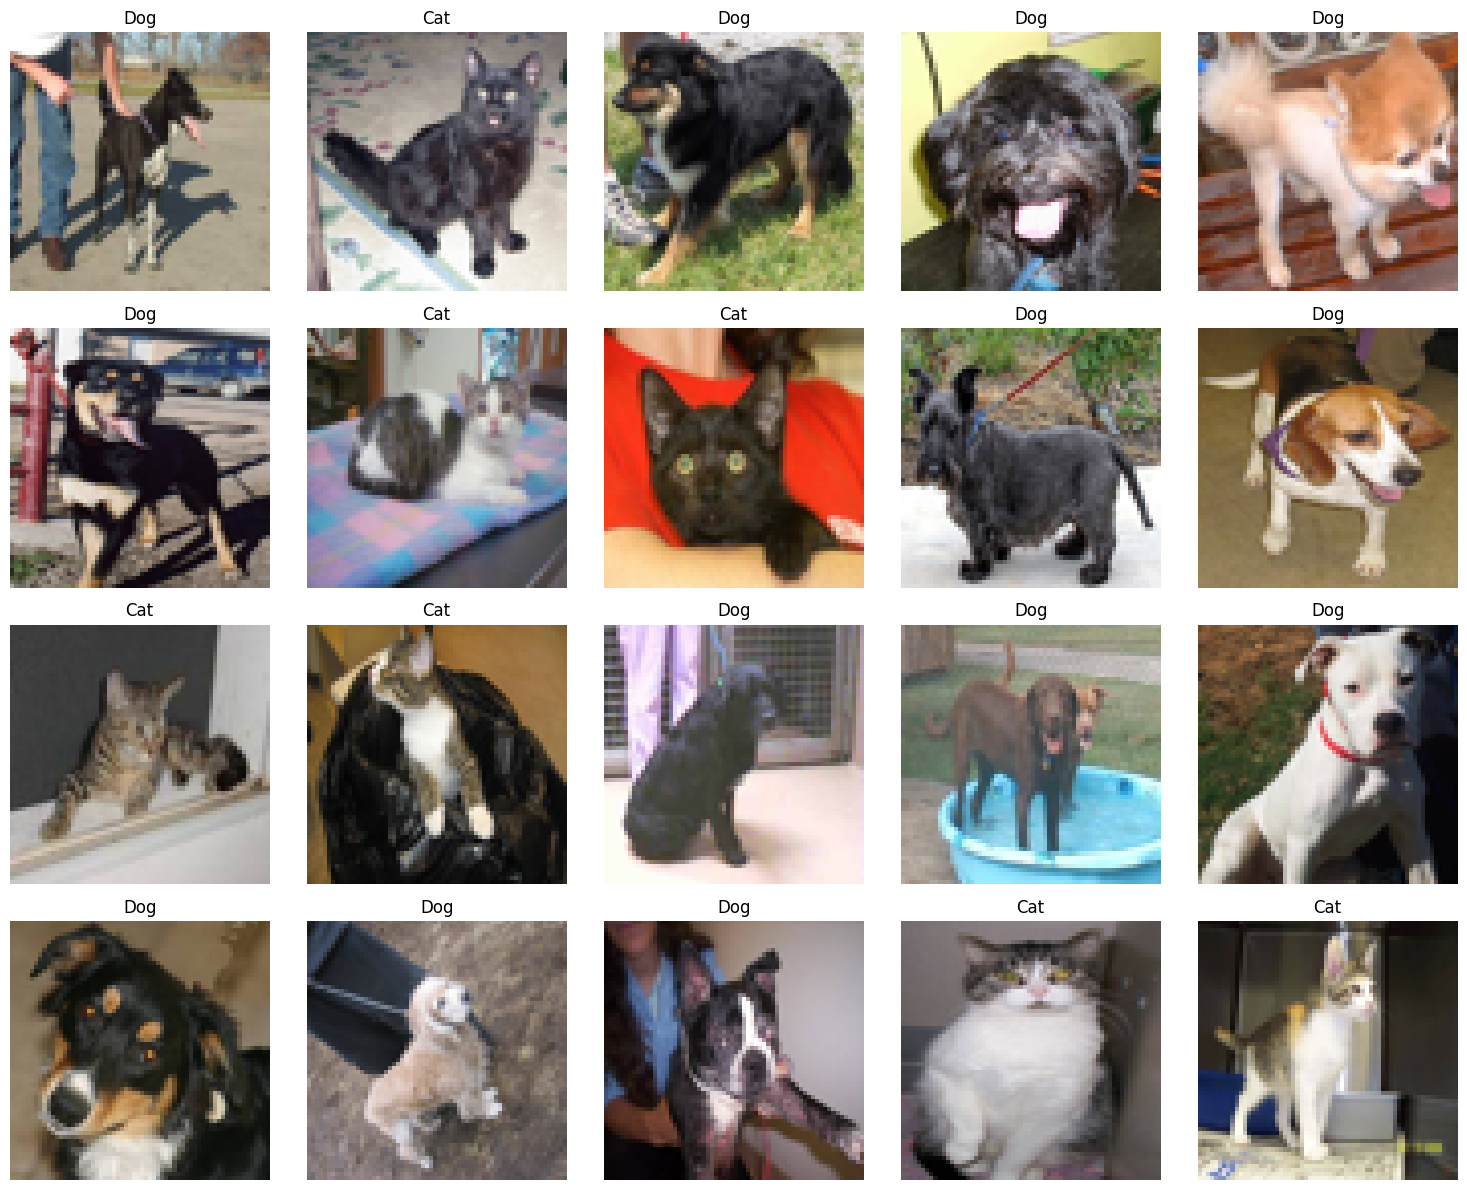

Shape of images array: (10000, 64, 64, 3)


In [13]:
# ipython-input-0-5c293b9f6ca8
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

# ipython-input-9-5c293b9f6ca8
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# ipython-input-10-5c293b9f6ca8
print("Shape of images array:", images.shape) # The images variable is now available in scope

# Display the shape of the first image

In [14]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


 # Display the first 2 images

In [15]:
print(images[:2])
print(labels[:2])

[[[[0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   ...
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]]

  [[0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   ...
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]]

  [[0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   ...
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]]

  ...

  [[0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   ...
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]
   [0.00195309 0.00392157 0.00390619]]

  [[0.00195309 0.00392157 0.00390619]
   [0.0

# Flattening the images for the SVM input

In [16]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

# Standardizing the features

In [17]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Applying t-SNE

In [18]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

# Splitting the dataset into training and test sets

In [19]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [20]:
X_train

array([[-0.80319044, -0.98843961, -1.05106869, ...,  1.66333861,
         1.69154742,  1.88824825],
       [-0.44529944, -0.61430865, -0.85330024, ..., -0.98944036,
        -1.06248899, -0.53977466],
       [ 1.22963046,  1.4578013 ,  1.46341591, ..., -0.1250517 ,
        -0.39299947, -0.64340978],
       ...,
       [ 1.9597281 ,  2.03338739,  2.11322653, ..., -0.52743952,
        -0.0126077 , -0.74704491],
       [ 0.29911385,  0.50808424,  0.36156311, ...,  1.52920934,
         1.67633175,  1.84383319],
       [-1.218344  , -1.16111544, -1.20645818, ..., -1.73460299,
        -1.76240984, -1.59093092]])

In [21]:
X_val

array([[-0.144671  , -0.15383977,  0.75710001, ...,  0.7542402 ,
         0.80903852,  1.88824825],
       [ 0.24185129,  1.28512547, -0.92393183, ..., -0.58705253,
         0.67209748, -1.33924562],
       [ 1.6018371 ,  1.47219095,  1.78832122, ...,  1.27585404,
         0.97641089,  1.1776074 ],
       ...,
       [-1.01792504, -1.10355683, -1.10757396, ..., -1.24279565,
        -1.21464569, -1.22080548],
       [-1.10381888, -0.930881  , -0.75441601, ...,  0.21772311,
         0.32213705,  0.46696654],
       [ 0.17027309,  0.22029119,  0.2768052 , ...,  1.0075955 ,
         1.1285676 ,  1.22202245]])

In [22]:
X_val

array([[-0.144671  , -0.15383977,  0.75710001, ...,  0.7542402 ,
         0.80903852,  1.88824825],
       [ 0.24185129,  1.28512547, -0.92393183, ..., -0.58705253,
         0.67209748, -1.33924562],
       [ 1.6018371 ,  1.47219095,  1.78832122, ...,  1.27585404,
         0.97641089,  1.1776074 ],
       ...,
       [-1.01792504, -1.10355683, -1.10757396, ..., -1.24279565,
        -1.21464569, -1.22080548],
       [-1.10381888, -0.930881  , -0.75441601, ...,  0.21772311,
         0.32213705,  0.46696654],
       [ 0.17027309,  0.22029119,  0.2768052 , ...,  1.0075955 ,
         1.1285676 ,  1.22202245]])

In [23]:
y_val

array([0, 1, 1, ..., 0, 0, 0])

# Checking class distribution

In [24]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 5016, 1: 4984}


In [25]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

# Training the SVM model

In [7]:
#Import the SVC class from sklearn.svm module
from sklearn.svm import SVC

# Sample data (replace with your actual data)
x_train = [[1, 2], [2, 3], [3, 4], [4, 5]]  # Features
y_train = [0, 1, 0, 1]  # Labels

svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

SVC(kernel='linear')

# Making predictions on the validation set

In [11]:
#Import the SVC class from sklearn.svm module
from sklearn.svm import SVC

# Sample data (replace with your actual data)
x_train = [[1, 2], [2, 3], [3, 4], [4, 5]]  # Features
y_train = [0, 1, 0, 1]  # Labels

# Sample validation data (replace with your actual data)
X_val = [[2.5, 3.5], [3.5, 4.5]] # Features for validation

svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

y_val_pred = svm.predict(X_val)

In [12]:
y_val_pred

array([1, 1])

# Evaluating the model

In [14]:
#Import the SVC class from sklearn.svm module
from sklearn.svm import SVC
# Import necessary functions from sklearn.metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Sample data (replace with your actual data)
x_train = [[1, 2], [2, 3], [3, 4], [4, 5]]  # Features
y_train = [0, 1, 0, 1]  # Labels

# Sample validation data (replace with your actual data)
X_val = [[2.5, 3.5], [3.5, 4.5]] # Features for validation
# Labels for validation data
y_val = [1, 0] # You need to define the ground truth labels for your validation set

svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

y_val_pred = svm.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy: {val_accuracy}")
print(f"Classification Report:\n {val_class_report}")
print(f"Confusion Matrix:\n {val_conf_matrix}")

Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

         Cat       0.00      0.00      0.00         1
         Dog       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
 [[0 1]
 [0 1]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [15]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5000


# Classification Report

In [16]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.00      0.00      0.00         1
         Dog       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



# Confusion Matrix

Validation Confusion Matrix:
[[0 1]
 [0 1]]


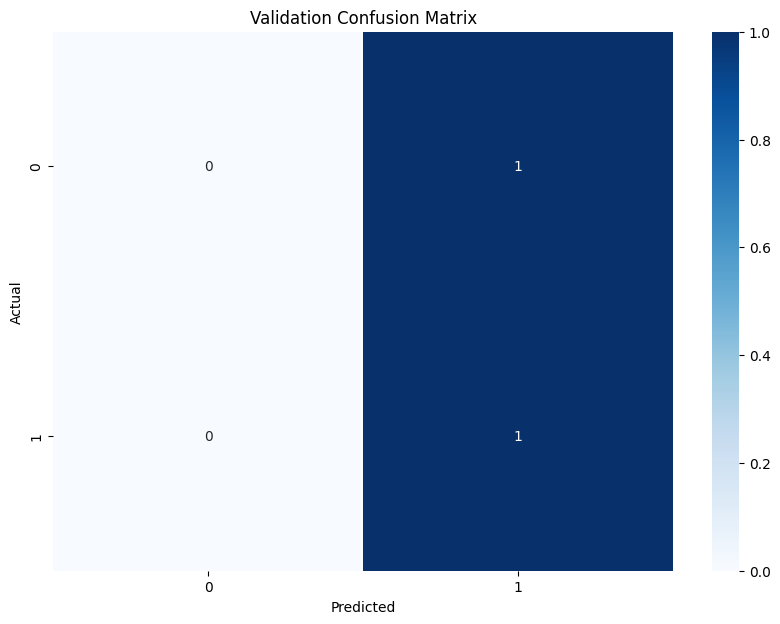

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # Added import statement for matplotlib.pyplot

print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

# Saving the SVM model and scaler

In [21]:
import pickle
from sklearn.preprocessing import StandardScaler # Import the StandardScaler

# Assuming you want to pickle a StandardScaler object
scaler = StandardScaler() # Create a StandardScaler object and assign it to the variable scaler

with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Loading and preprocessing the test data

In [32]:
!ls /kaggle/input/flowers-recognition/flowers/sunflower
import os
test_dir = os.path.abspath(test_dir)

import os
if os.path.isdir(test_dir):
    print(f"Directory '{test_dir}' exists.")
else:
    print(f"Directory '{test_dir}' does not exist.")

ls: cannot access '/kaggle/input/flowers-recognition/flowers/sunflower': No such file or directory
Directory '/kaggle/input/flowers-recognition/flowers/sunflower' does not exist.


# Flattening the test images for the SVM input

In [37]:
import numpy as np # Import the numpy module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)
    test_images_flat_scaled = scaler.transform(test_images_flat)
else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape

Error: test_images has an unexpected shape: (0,)


# Standardizing the test features

In [39]:
import numpy as np # Import the numpy module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)
    test_images_flat_scaled = scaler.transform(test_images_flat)
else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


# Applying t-SNE for visualization on test data

In [41]:
import numpy as np # Import the numpy module
from sklearn.manifold import TSNE # Import the TSNE module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)

    #Check if scaler is defined
    try:
        test_images_flat_scaled = scaler.transform(test_images_flat)
    except NameError:
        print("Scaler is not defined. Make sure you have defined and fit your scaler object.")

    # Determine a new perplexity value for the test data
    test_perplexity = min(30, n_test_samples - 1)

    # Create a new t-SNE instance for the test data
    test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
    test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


# Making predictions on the test set

In [44]:
import numpy as np # Import the numpy module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)
    test_images_flat_scaled = scaler.transform(test_images_flat) # Make sure scaler is defined and fit before this line
else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


In [53]:
# Make sure you have defined and trained your model
# For example, if you are using scikit-learn:
from sklearn.linear_model import LogisticRegression  # Import a model class

model = LogisticRegression() # Create an instance of the model

# Assuming you have your features and labels in X and y
# ----> Define X with your features data
X = [[1, 2], [3, 4], [5, 6], [7, 8]] # Example feature data, replace with your actual data

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

model.fit(x_train, y_train) # Train the model

# Now you can use the trained model to make predictions
y_test_pred = model.predict(x_test)

# Now you can access y_test_pred
y_test_pred

array([0])

# Creating a DataFrame for Plotly

In [64]:
import numpy as np # Import the numpy module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)

    # Make sure scaler is defined and fit before this line
    # If not defined, define and fit it to your training data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X) # Assuming X is your training data

    test_images_flat_scaled = scaler.transform(test_images_flat)

    # Apply t-SNE to reduce the dimensionality to 2 components
    from sklearn.manifold import TSNE #Import TSNE
    test_images_tsne = TSNE(n_components=2).fit_transform(test_images_flat_scaled)

    import pandas as pd # Import the pandas library and assign it to the alias 'pd'

    df_test_tsne = pd.DataFrame()
    df_test_tsne['X'] = test_images_tsne[:, 0]
    df_test_tsne['Y'] = test_images_tsne[:, 1]
    df_test_tsne['Predicted Label'] = y_test_pred
    df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


# Plotting with Plotly

In [74]:
import numpy as np # Import the numpy module

# Assuming test_images is a list of image data
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)

    # Make sure scaler is defined and fit before this line
    # If not defined, define and fit it to your training data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X) # Assuming X is your training data

    test_images_flat_scaled = scaler.transform(test_images_flat)

    # Apply t-SNE to reduce the dimensionality to 2 components
    from sklearn.manifold import TSNE #Import TSNE
    test_images_tsne = TSNE(n_components=2).fit_transform(test_images_flat_scaled)

    import pandas as pd # Import the pandas library and assign it to the alias 'pd'

    df_test_tsne = pd.DataFrame({'X':test_images_tsne[:, 0],
                                 'Y':test_images_tsne[:, 1],
                                 'Predicted Label':y_test_pred}) # Create the DataFrame in one step
    df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    # Print some info to check
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Shape of test_images_tsne: {test_images_tsne.shape}")
    print(f"df_test_tsne head: \n {df_test_tsne.head()}")

else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


# Visualizing some of the test results with Plotly

In [76]:
import numpy as np # Import the numpy module
from sklearn.manifold import TSNE #Import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd # Import the pandas library and assign it to the alias 'pd'

# Assuming test_images and X are defined somewhere above
# Convert test_images to a NumPy array
test_images = np.array(test_images)

# Check if the conversion was successful and the array has the expected shape
if test_images.ndim == 4:
    n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
    test_images_flat = test_images.reshape(n_test_samples, -1)

    # Make sure scaler is defined and fit before this line
    # If not defined, define and fit it to your training data
    scaler = StandardScaler()
    scaler.fit(X) # Assuming X is your training data

    test_images_flat_scaled = scaler.transform(test_images_flat)

    # Apply t-SNE to reduce the dimensionality to 2 components
    test_images_tsne = TSNE(n_components=2).fit_transform(test_images_flat_scaled)

    df_test_tsne = pd.DataFrame({'X':test_images_tsne[:, 0],
                                 'Y':test_images_tsne[:, 1],
                                 'Predicted Label':y_test_pred}) # Create the DataFrame in one step
    df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    # Print some info to check
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Shape of test_images_tsne: {test_images_tsne.shape}")
    print(f"df_test_tsne head: \n {df_test_tsne.head()}")


    def plot_test_samples(images, tsne_data, predictions, sample_count=10):
        sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
        sample_images = images[sample_indices]
        tsne_samples = tsne_data[sample_indices]
        pred_samples = predictions[sample_indices]

        fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                         title="Test Data Predictions (t-SNE Space)")
        fig.show()

    plot_test_samples(test_images, test_images_tsne, y_test_pred)

else:
    print(f"Error: test_images has an unexpected shape: {test_images.shape}")
    # Handle the case where test_images does not have the expected shape,
    # e.g., by reshaping it or printing additional debugging information
    # For example, you could print the shape and data type of test_images
    print(f"Shape of test_images: {test_images.shape}")
    print(f"Data type of test_images: {test_images.dtype}")

Error: test_images has an unexpected shape: (0,)
Shape of test_images: (0,)
Data type of test_images: float64


# Saving the test predictions to a CSV file

In [78]:
import numpy as np # Import the numpy module
import pandas as pd # Import the pandas library and assign it to the alias 'pd'

# Assuming y_test_pred is your prediction array
n_test_samples = len(y_test_pred) # Get the number of test samples from y_test_pred

test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [95]:
# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=1, random_state=42) # Set perplexity to 1, less than the number of samples
val_images_tsne = val_tsne.fit_transform(X_val)

# Convert y_val to a NumPy array
y_val = np.array(y_val) # Use np.array to convert the list to a NumPy array

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred, sample_count=2) # Set sample_count to 2 or less